<a href="https://colab.research.google.com/github/danisjc6/treinamento_figado_felino/blob/main/treinamento_felino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

preparando o ambiente

In [ ]:
!pip install pyyaml==6.0.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.0/725.0 kB 51.2 MB/s eta 0:00:00
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0.3
    Uninstalling PyYAML-6.0.3:
      Successfully uninstalled PyYAML-6.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.21.0 requires PyYAML<7.0.0,>=6.0.2, but you have pyyaml 6.0.1 which is incompatible.


In [ ]:
import sys
import os
import distutils.core

In [ ]:
import yaml
print(yaml.__version__)


6.0.1


In [ ]:
!pip install torch torchvision torchaudio --index-url https:download.pytorch.org/whl/cu118

Looking in indexes: https:download.pytorch.org/whl/cu118


In [ ]:
!nvidia-smi

Fri Jan  2 19:28:11 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install opencv-python-headless
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-3bhxhd4l
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-3bhxhd4l
  Resolved https://github.com/facebookresearch/detectron2.git to commit fd27788985af0f4ca800bca563acdb700bb890e2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 82.9 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=7084955 sha256=4b5c388604346bbe941add3439f2f73f834a45ea6d017dfe143f49a967ad21af
  Stored in directory: /tmp/pip-ephem-wheel-cache-b__zn97f/wheels/d3/6e/bd/1969578f1456a6be

In [ ]:
import torch
import detectron2
import cv2
import os
import json
import random

print("Torch:", torch.__version__)
print("Detectron2 OK")
print("CUDA disponível:", torch.cuda.is_available())


Torch: 2.9.0+cu126
Detectron2 OK
CUDA disponível: True


Organizando os arquivos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import random

BASE_DIR = os.path.join("/content/drive/MyDrive", "treinamento_figado")

ROTULOS = {
    "felino": os.path.join(BASE_DIR, "rotulos/felino"),
}

IMAGENS = {
    "felino": os.path.join(BASE_DIR, "dataset_figado/figado_felino/images"),
}

OUTPUT = os.path.join(BASE_DIR, "dataset_figado_felino")

TRAIN_RATIO = 0.8
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [ ]:
# =========================
# CRIAR PASTAS
# =========================
for split in ["train", "val"]:
    os.makedirs(os.path.join(OUTPUT, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT, split, "annotations"), exist_ok=True)

import os
import json
import shutil
import random

BASE_DIR = "/content/drive/MyDrive/treinamento_figado_felino"

ROTULOS = {
    "felino": os.path.join(BASE_DIR, "rotulos_figado_felino"),
}

IMAGENS = {
    "felino": os.path.join(BASE_DIR, "dataset_figado_felino"),
}

OUT = os.path.join(BASE_DIR, "dataset_detectron")

EXTS = [".jpg", ".jpeg", ".png"]

def encontrar_imagem(nome_base, pasta_imgs):
    for ext in EXTS:
        p = os.path.join(pasta_imgs, nome_base + ext)
        if os.path.exists(p):
            return p
    return None

def process_species(species, split=0.8):
    jsons = [f for f in os.listdir(ROTULOS[species]) if f.endswith(".json")]
    random.shuffle(jsons)

    n_train = int(len(jsons) * split)
    train_jsons = jsons[:n_train]
    val_jsons = jsons[n_train:]

    for phase, lista in [("train", train_jsons), ("val", val_jsons)]:
        img_out = os.path.join(OUT, species, phase, "images")
        ann_out = os.path.join(OUT, species, phase, "annotations")
        os.makedirs(img_out, exist_ok=True)
        os.makedirs(ann_out, exist_ok=True)

        for jf in lista:
            base = os.path.splitext(jf)[0]
            img_path = encontrar_imagem(base, IMAGENS[species])

            if img_path is None:
                print(f"⚠️ Imagem não encontrada para {jf}")
                continue

            shutil.copy(img_path, img_out)
            shutil.copy(
                os.path.join(ROTULOS[species], jf),
                ann_out
            )

    print(f"✅ {species.upper()} processado com sucesso")

process_species("felino")

# =========
# PROCESSAR
# =========

process_species("felino")

print("✔ Divisão concluída com sucesso")

✅ FELINO processado com sucesso
✅ FELINO processado com sucesso
✔ Divisão concluída com sucesso


In [ ]:
import os
import json
import cv2
import numpy as np

BASE_DIR = "/content/drive/MyDrive/treinamento_figado_felino/dataset_detectron"

CLASS_MAP = {
    "figado_felino": 0,
    "processo_papilar_felino": 1,
}

VALID_EXTS = (".jpg", ".jpeg", ".png")

def polygon_to_bbox(seg):
    xs = seg[0::2]
    ys = seg[1::2]
    return [min(xs), min(ys), max(xs)-min(xs), max(ys)-min(ys)]

def convert_split(species, split):
    img_dir = os.path.join(BASE_DIR, species, split, "images")
    ann_dir = os.path.join(BASE_DIR, species, split, "annotations")

    dataset = []

    for img_id, img_name in enumerate(sorted(os.listdir(img_dir))):
        if not img_name.lower().endswith(VALID_EXTS):
            continue

        base = os.path.splitext(img_name)[0]
        img_path = os.path.join(img_dir, img_name)
        json_path = os.path.join(ann_dir, base + ".json")

        if not os.path.exists(json_path):
            continue

        img = cv2.imread(img_path)
        h, w = img.shape[:2]

        with open(json_path) as f:
            data = json.load(f)

        annotations = []

        for shape in data["shapes"]:
            label = shape["label"].lower()


            if label not in CLASS_MAP:
                continue

            points = np.array(shape["points"], dtype=np.int32)
            segmentation = points.flatten().tolist()
            bbox = polygon_to_bbox(segmentation)

            annotations.append({
                "category_id": CLASS_MAP[label],
                "segmentation": [segmentation],
                "bbox": bbox,
                "bbox_mode": 1,  # BoxMode.XYWH_ABS
                "iscrowd": 0
            })

        # 👉 ignora imagens sem anotações válidas
        if len(annotations) == 0:
            continue

        dataset.append({
            "file_name": img_path,
            "image_id": img_id,
            "height": h,
            "width": w,
            "annotations": annotations
        })

    return dataset

# ==============
# GERAR DATASETS
# ==============
datasets = {}

for species in ["felino"]:
    for split in ["train", "val"]:
        name = f"{species}_{split}"
        datasets[name] = convert_split(species, split)
        print(f"✅ {name}: {len(datasets[name])} imagens")


✅ felino_train: 53 imagens
✅ felino_val: 20 imagens


In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

CLASS_NAMES = [
    "figado_felino",
    "processo_papilar_felino",
]

def register_dataset(name, data):
    DatasetCatalog.register(name, lambda d=data: d)
    MetadataCatalog.get(name).set(
        thing_classes=CLASS_NAMES
    )

for name, data in datasets.items():
    register_dataset(name, data)
    print(f"📌 Dataset registrado: {name}")

📌 Dataset registrado: felino_train
📌 Dataset registrado: felino_val


Treinamento do modelo

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

def train_model(species, classes, output_dir):
    cfg = get_cfg()
    cfg.merge_from_file(
        model_zoo.get_config_file(
            "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
        )
    )

    cfg.DATASETS.TRAIN = (f"{species}_train",)
    cfg.DATASETS.TEST = (f"{species}_val",)

    cfg.DATALOADER.NUM_WORKERS = 2

    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    )

    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 1000   # ideal para dataset pequeno
    cfg.SOLVER.STEPS = []        # sem decaimento
    cfg.SOLVER.WARMUP_ITERS = 100

    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

    cfg.TEST.EVAL_PERIOD = 200

    cfg.OUTPUT_DIR = output_dir
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

    return cfg

In [ ]:
cfg_felino = train_model(
    species="felino",
    classes=["figado_felino", "processo_papilar_felino"],
    output_dir="/content/drive/MyDrive/treinamento_figado_felino/output/felino"
)


[01/02 19:42:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[01/02 19:42:45 d2.engine.train_loop]: Starting training from iteration 0
[01/02 19:43:02 d2.utils.events]:  eta: 0:12:43  iter: 19  total_loss: 2.517  loss_cls: 1.118  loss_box_reg: 0.6805  loss_mask: 0.6827  loss_rpn_cls: 0.0413  loss_rpn_loc: 0.005849    time: 0.8378  last_time: 0.7197  data_time: 0.4054  last_data_time: 0.3102   lr: 4.7702e-05  max_mem: 3921M
[01/02 19:43:19 d2.utils.events]:  eta: 0:12:37  iter: 39  total_loss: 1.912  loss_cls: 0.596  loss_box_reg: 0.6795  loss_mask: 0.5444  loss_rpn_cls: 0.0202  loss_rpn_loc: 0.004419    time: 0.8353  last_time: 0.6590  data_time: 0.3959  last_data_time: 0.3204   lr: 9.7652e-05  max_mem: 3921M
[01/02 19:43:36 d2.utils.events]:  eta: 0:12:27  iter: 59  total_loss: 1.472  loss_cls: 0.358  loss_box_reg: 0.7288  loss_mask: 0.3513  loss_rpn_cls: 0.03235  loss_rpn_loc: 0.004799    time: 0.8341  last_time: 0.7354  data_time: 0.3672  last_data_time: 0.2671   lr: 0.0001476  max_mem: 3922M
[01/02 19:43:55 d2.utils.events]:  eta: 0:12:11  i

avaliação das predições

In [ ]:
import cv2
import random
import matplotlib.pyplot as plt

from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.config import get_cfg
from detectron2 import model_zoo


In [ ]:
def visualizar_predicoes(
    dataset_name,
    output_dir,
    classes,
    score_thresh=0.5,
    num_images=5
):
    # =========================
    # CONFIG DO MODELO
    # =========================
    cfg = get_cfg()
    cfg.merge_from_file(
        model_zoo.get_config_file(
            "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
        )
    )

    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
    cfg.MODEL.WEIGHTS = f"{output_dir}/model_final.pth"
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_thresh
    cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    predictor = DefaultPredictor(cfg)

    metadata = MetadataCatalog.get(dataset_name)
    dataset = DatasetCatalog.get(dataset_name)

    # =========================
    # SELECIONA IMAGENS
    # =========================
    samples = random.sample(dataset, min(num_images, len(dataset)))

    for sample in samples:
        img = cv2.imread(sample["file_name"])
        outputs = predictor(img)

        v = Visualizer(
            img[:, :, ::-1],
            metadata=metadata,
            scale=1.0
        )

        out = v.draw_instance_predictions(
            outputs["instances"].to("cpu")
        )

        plt.figure(figsize=(10, 10))
        plt.imshow(out.get_image())
        plt.axis("off")
        plt.show()


[01/02 19:57:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/treinamento_figado_felino/output/felino/model_final.pth ...


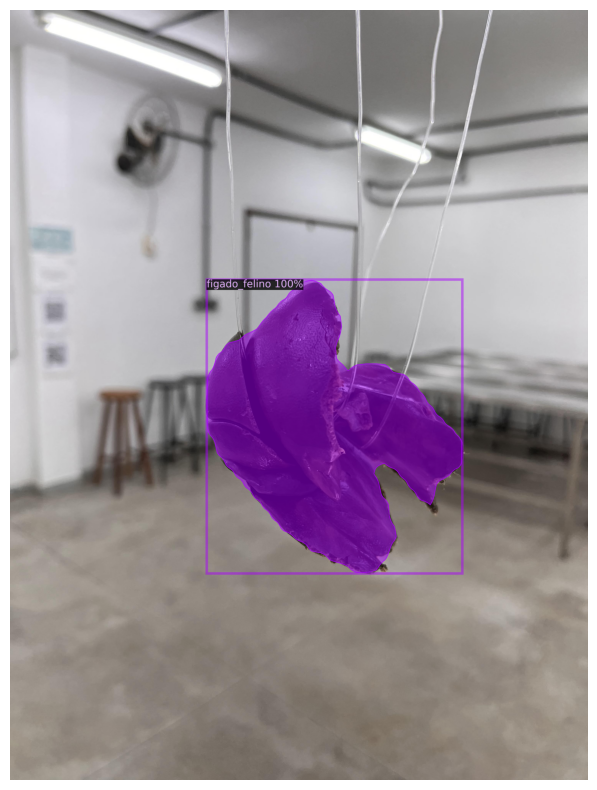

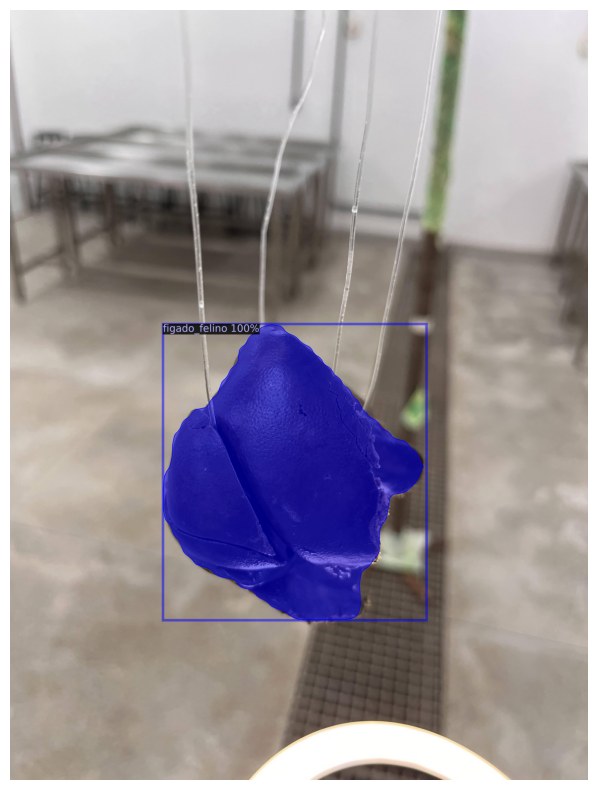

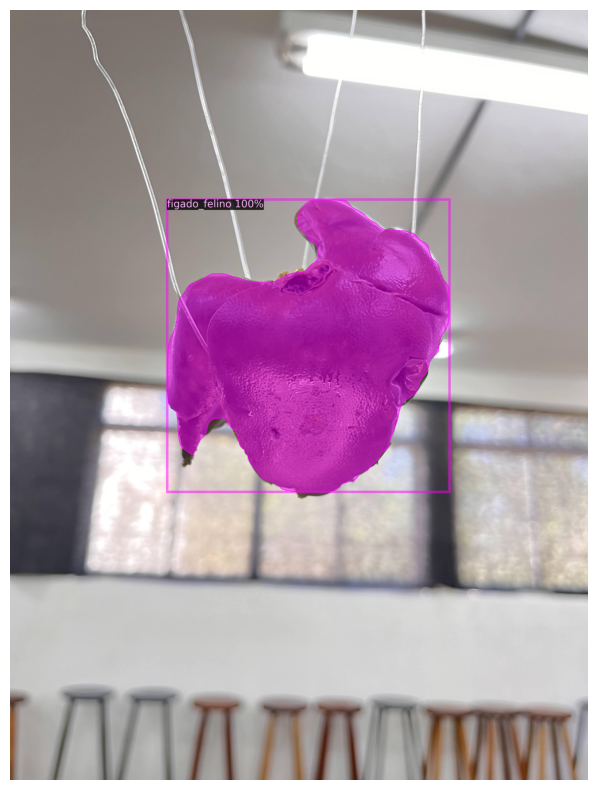

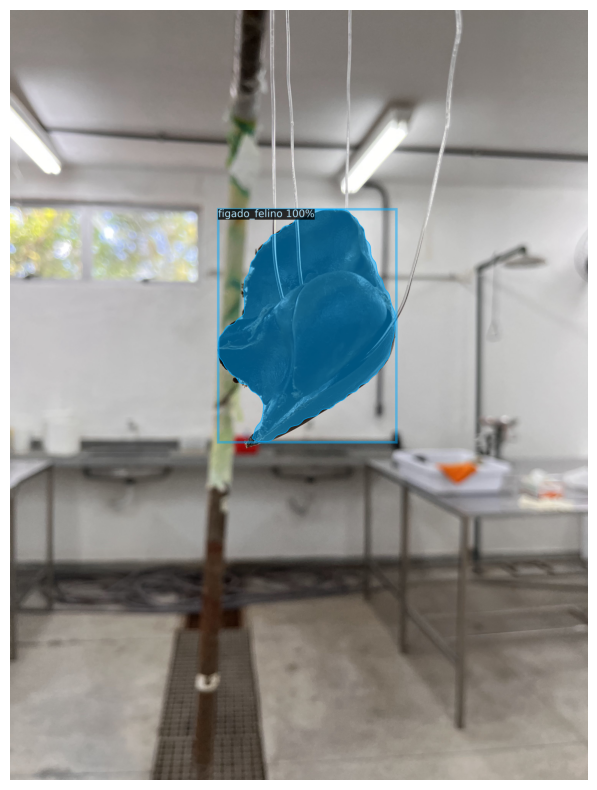

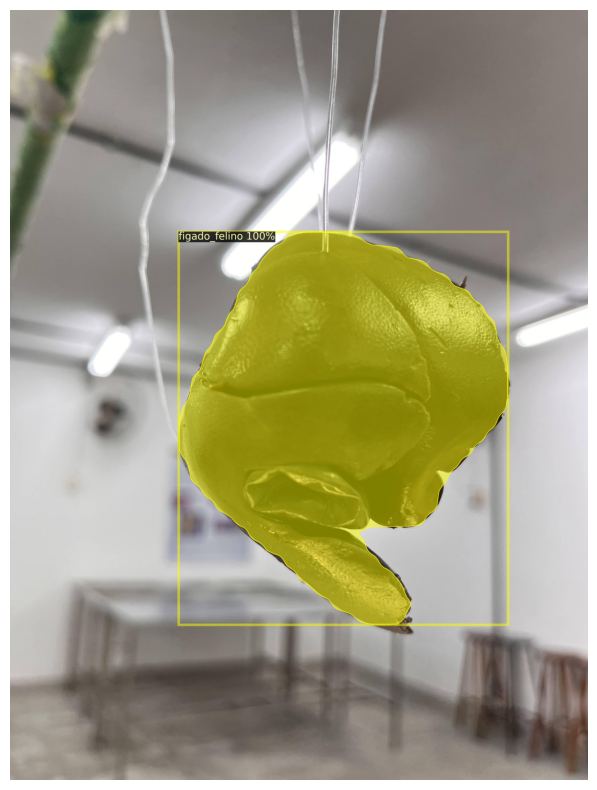

In [ ]:
visualizar_predicoes(
    dataset_name="felino_val",
    output_dir="/content/drive/MyDrive/treinamento_figado_felino/output/felino",
    classes=["figado_felino", "processo_papilar_felino"],
    score_thresh=0.5,
    num_images=5
)

Avaliar AP por classe

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os


In [ ]:
def avaliar_ap_por_classe(
    dataset_name,
    output_dir,
    num_classes,
    classes,
    model_config="COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml",
):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(model_config))
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    cfg.MODEL.WEIGHTS = os.path.join(output_dir, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
    cfg.MODEL.DEVICE = "cuda"

    predictor = DefaultPredictor(cfg)

    evaluator = COCOEvaluator(
        dataset_name,
        cfg,
        False,
        output_dir=os.path.join(output_dir, "eval")
    )

    val_loader = build_detection_test_loader(cfg, dataset_name)

    results = inference_on_dataset(
        predictor.model,
        val_loader,
        evaluator
    )

    print("\n📊 RESULTADOS GERAIS")
    print(results["segm"])

    print("\n📌 AP POR CLASSE")
    for i, cls in enumerate(classes):
        ap = results["segm"]["AP-per-class"][i]
        print(f"• {cls}: AP = {ap:.2f}")

    return results

In [ ]:
avaliar_ap_por_classe(
    dataset_name="felino_val",
    output_dir="/content/drive/MyDrive/treinamento_figado_felino/output/felino",
    num_classes=2,
    classes=["figado_felino", "processo_papilar_felino"]
)

[01/02 19:59:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/treinamento_figado_felino/output/felino/model_final.pth ...
WARNING [01/02 19:59:13 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/02 19:59:13 d2.evaluation.coco_evaluation]: Trying to convert 'felino_val' to COCO format ...
[01/02 19:59:13 d2.data.datasets.coco]: Converting annotations of dataset 'felino_val' to COCO format ...)
[01/02 19:59:13 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/02 19:59:13 d2.data.datasets.coco]: Conversion finished, #images: 20, #annotations: 26
[01/02 19:59:13 d2.data.datasets.coco]: Caching COCO format annotations at '/content/drive/MyDrive/treinamento_figado_felino/output/felino/eval/felino_val_coco_format.json' ...
[01/02 19:59:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShort

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[01/02 19:59:19 d2.evaluation.evaluator]: Inference done 11/20. Dataloading: 0.0367 s/iter. Inference: 0.1431 s/iter. Eval: 0.2265 s/iter. Total: 0.4063 s/iter. ETA=0:00:03
[01/02 19:59:23 d2.evaluation.evaluator]: Total inference time: 0:00:06.818642 (0.454576 s / iter per device, on 1 devices)
[01/02 19:59:23 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.150452 s / iter per device, on 1 devices)
[01/02 19:59:23 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/02 19:59:23 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/treinamento_figado_felino/output/felino/eval/coco_instances_results.json
[01/02 19:59:23 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[01/02 19:59:23 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[01/02 19:59:23 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate

KeyError: 'AP-per-class'